# Learning a temporal convolution

The example in this notebook demonstrates the use of the `learnable = True` flag passed to the `TemporalBasisTrafo` constructor.
In this mode, the `TemporalBasisTrafo` layer will learn a temporal convolution.
The resulting type of network is also called a "Temporal Convolution Network".

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np

import tensorflow as tf
tf.get_logger().setLevel('ERROR') # Silence warnings when re-loading the model below

import scipy.signal
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

from temporal_basis_transformation_network.keras import TemporalBasisTrafo

## Dataset generation

The toy dataset we're using here simply consists of two alternating sine-waves of different frequencies.
The network has to classify which sine-wave is currently active.

In [6]:
def mk_alternating_frequencies(T=1000.0, dt=1e-3, fs=(50, 100), rng=np.random):
    N_ts = int(T / dt)
    xs = np.zeros(N_ts)
    ys = np.zeros((N_ts, len(fs)))
    T_switch, fi = 0.0, 0
    for i in range(N_ts):
        T_switch -= dt
        if T_switch <= 0.0:
            T_switch = rng.uniform(0.1, 0.5)
            fi = (fi + 1) % len(fs)
        xs[i] = np.sin(2.0 * np.pi * i * dt * fs[fi])
        ys[i, fi] = 1.0
    xs += 0.1 * rng.randn(N_ts)
    return xs, ys

def mk_tf_dset(N_wnd, N_chunks, xs, ys, N_batch=100, rng=np.random):
    xs_chk = np.zeros((N_chunks, N_wnd, 1))
    ys_chk = np.zeros((N_chunks, 1, ys.shape[1]))
    for i in range(N_chunks):
        i0 = np.random.randint(0, xs.shape[0] - N_wnd)
        i1 = i0 + N_wnd
        xs_chk[i, :, 0], ys_chk[i, 0] = xs[i0:i1], ys[i1 - 1]
    ds = tf.data.Dataset.from_tensor_slices((xs_chk, ys_chk))
    ds = ds.shuffle(N_chunks)
    ds = ds.batch(N_batch)
    return ds

In [7]:
rng_train = np.random.RandomState(8879)
rng_val = np.random.RandomState(57171)
rng_test = np.random.RandomState(4189)
xs_train, ys_train = mk_alternating_frequencies(rng=rng_train)
xs_val, ys_val = mk_alternating_frequencies(rng=rng_val)
xs_test, ys_test = mk_alternating_frequencies(rng=rng_test)

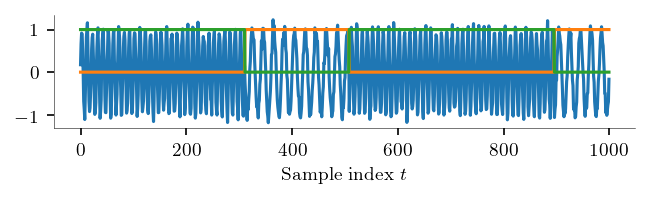

In [8]:
fig, ax = plt.subplots(figsize=(5.0, 1.0), sharex=True)
ax.plot(xs_train[:1000])
ax.plot(ys_train[:1000])
ax.set_xlabel('Sample index $t$');

In [9]:
N_wnd = 32
ds_train = mk_tf_dset(N_wnd, 10000, xs_train, ys_train, rng=rng_train)
ds_val = mk_tf_dset(N_wnd, 1000, xs_val, ys_val, rng=rng_val)
ds_test = mk_tf_dset(N_wnd, 1000, xs_test, ys_test, rng=rng_test)

## Model

The model consists of a single `TemporalBasisTrafo` instance with a single unit, followed by a layer of `ReLU` units and a linear readout.

In [28]:
def mk_model(N_wnd, pad=False, q=4, N_out=2, N_neurons=100):
    model = tf.keras.models.Sequential([
        TemporalBasisTrafo((q, N_wnd), pad=pad, trainable=True, initializer='he_normal'),      # (1, q)
        tf.keras.layers.Dense(N_neurons, activation='relu'), # (1, N_neurons)
        tf.keras.layers.Dropout(0.25),                       # (1, N_neurons)
        tf.keras.layers.Dense(N_out, use_bias=False),        # (1, N_out)
    ])
    return model

In [29]:
model = mk_model(N_wnd)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.fit(ds_train, epochs=10, validation_data=ds_val)

fn = '/tmp/temporal_convolution_weights'
model.save_weights(fn)

res = model.evaluate(ds_test, verbose=False)
print('Test accuracy {:0.2f}%; loss = {:0.4f}'.format(100 * res[1], res[0]))

model.summary()

Epoch 1/10
100/100 [==============================] - 1s 3ms/step - loss: 0.5687 - accuracy: 0.7174 - val_loss: 0.2449 - val_accuracy: 0.9490
Epoch 2/10
100/100 [==============================] - 0s 2ms/step - loss: 0.2287 - accuracy: 0.9468 - val_loss: 0.1607 - val_accuracy: 0.9550
Epoch 3/10
100/100 [==============================] - 0s 2ms/step - loss: 0.1605 - accuracy: 0.9582 - val_loss: 0.1192 - val_accuracy: 0.9690
Epoch 4/10
100/100 [==============================] - 0s 2ms/step - loss: 0.1376 - accuracy: 0.9632 - val_loss: 0.0951 - val_accuracy: 0.9750
Epoch 5/10
100/100 [==============================] - 0s 2ms/step - loss: 0.1143 - accuracy: 0.9720 - val_loss: 0.0801 - val_accuracy: 0.9780
Epoch 6/10
100/100 [==============================] - 0s 2ms/step - loss: 0.0942 - accuracy: 0.9775 - val_loss: 0.0701 - val_accuracy: 0.9810
Epoch 7/10
100/100 [==============================] - 0s 2ms/step - loss: 0.0931 - accuracy: 0.9792 - val_loss: 0.0625 - val_accuracy: 0.9850
Epoch 

## Evaluation

To see what the model is doing, we can evaluate it on a longer time-series.

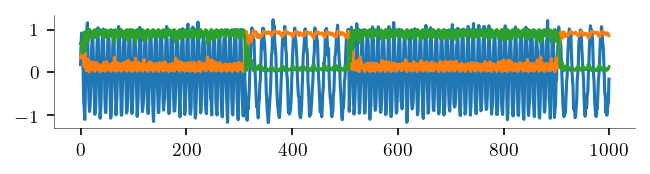

In [30]:
# Construct the model another time and load the weights. Unfortunately, as of
# now, TensorFlow does not call build() again when evaluating the network with
# a different input shape
model_eval = mk_model(N_wnd, pad=True)
model_eval.load_weights(fn)
ys_train_hat = model_eval(xs_train[:1000].reshape(-1, 1)).numpy()
fig, ax = plt.subplots(figsize=(5.0, 1.0))
ax.plot(xs_train[:1000])
ax.plot(1.0 - 1.0 / (1.0 + np.exp(ys_train_hat)));

Access the learned filters using `TemporalBasisTransformation.kernel()`

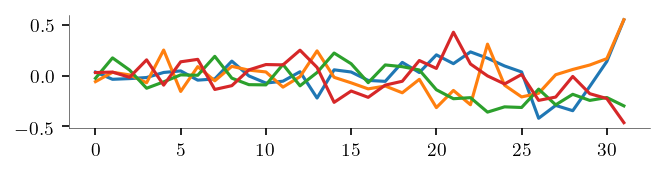

In [31]:
fig, ax = plt.subplots(figsize=(5.0, 1.0))
ax.plot(model_eval.layers[0].kernel().T);